In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize
from sklearn.model_selection import KFold
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2


In [3]:
DATASET = "aerial"

In [4]:
BASE_DIR = f"/home/vblot/multiaccurate_cp/data/{DATASET}"
MODELS_PATH = f"/home/vblot/multiaccurate_cp/data/{DATASET}/03_model_weights/resnet"
MODEL_NAME = "20240322_1039"

In [5]:
# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [6]:
config

{'mean_RGB_values_path': 'data/01_raw_images/rgb_means.npy',
 'ml_data_dir': 'data/02_prepared_data',
 'model': {'batch_size': 40,
  'embedding_size': 1024,
  'epochs': 100,
  'lr': 0.0001,
  'model_input': 'image_and_probas',
  'num_workers': 8,
  'patience': 20,
  'resnet': 'resnet50',
  'target_recall': 0.9},
 'output_dir': 'data/03_model_weights/resnet',
 'probas_dir': 'data/04_predictions'}

In [7]:
IMG_SIZE = 64
EMBEDDING_SIZE = config["model"]["embedding_size"]

In [8]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")


In [9]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(tqdm(zip(sorted(os.listdir(pred_probas_dir)),
                                                                       sorted(os.listdir(res_emb_dir)),
                                                                       sorted(os.listdir(labels_dir))))):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [10]:
cal_pred_probas, cal_res_emb, cal_labels = load_data(DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS)


1500it [00:02, 583.17it/s]


In [11]:
test_pred_probas, test_res_emb, test_labels = load_data(DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS)

2300it [00:03, 595.68it/s]


In [12]:
all_pred_probas = np.concatenate([cal_pred_probas, test_pred_probas])
all_res_emb = np.concatenate([cal_res_emb, test_res_emb])
all_labels = np.concatenate([cal_labels, test_labels])

In [15]:
all_pred_probas.shape

(3800, 64, 64)

In [13]:
ALPHA = .1

In [16]:
recalls = []
precisions = []

for _ in tqdm(range(100)):
    cal_inx = np.random.choice(range(len(all_pred_probas)), len(all_pred_probas) // 2 , replace=False)
    test_inx = np.array([i for i in range(len(all_pred_probas)) if i not in cal_inx])
    temp_cal_pred_probas = all_pred_probas[cal_inx]
    temp_cal_res_emb = all_res_emb[cal_inx]
    temp_cal_labels = all_labels[cal_inx]

    index_not_empy = np.where(temp_cal_labels.sum(axis=(1, 2)) > 0)[0]
    temp_cal_labels = temp_cal_labels[index_not_empy]
    temp_cal_res_emb = temp_cal_res_emb[index_not_empy]
    temp_cal_pred_probas = temp_cal_pred_probas[index_not_empy]

    temp_test_pred_probas = all_pred_probas[test_inx]
    temp_test_res_emb = all_res_emb[test_inx]
    temp_test_labels = all_labels[test_inx]

    print(temp_cal_pred_probas.shape, temp_test_pred_probas.shape)

    n = len(temp_cal_pred_probas)

    result = minimize(
        J, np.random.uniform(0, 1, EMBEDDING_SIZE),
        method="SLSQP",
        args=(temp_cal_labels, temp_cal_pred_probas, temp_cal_res_emb, ALPHA, n), jac=J_prime,
        options={"disp": False, "maxiter": 10000}
    )

    ths = np.maximum((temp_test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
    y_pred_test_th = (temp_test_pred_probas >= ths).astype(int)
    recall_test = (y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / temp_test_labels.sum(axis=(1, 2))
    precision_test = np.nan_to_num((y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
    recalls.append(np.nanmean(recall_test))
    precisions.append(np.nanmean(precision_test))
    print(np.nanmean(recall_test))

    


  0%|          | 0/100 [00:00<?, ?it/s]

(1563, 64, 64) (1900, 64, 64)


/tmp/ipykernel_1851819/56335789.py:33: RuntimeWarning: invalid value encountered in divide
  recall_test = (y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / temp_test_labels.sum(axis=(1, 2))
/tmp/ipykernel_1851819/56335789.py:34: RuntimeWarning: invalid value encountered in divide
  precision_test = np.nan_to_num((y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
  1%|          | 1/100 [00:40<1:06:15, 40.16s/it]

0.8726448475343862
(1572, 64, 64) (1900, 64, 64)


  2%|▏         | 2/100 [01:49<1:33:13, 57.08s/it]

0.8774388777664789
(1557, 64, 64) (1900, 64, 64)


  3%|▎         | 3/100 [02:35<1:24:17, 52.14s/it]

0.8857847290056939
(1575, 64, 64) (1900, 64, 64)


  4%|▍         | 4/100 [03:13<1:14:44, 46.71s/it]

0.8888557488476775
(1574, 64, 64) (1900, 64, 64)


  5%|▌         | 5/100 [04:28<1:29:44, 56.68s/it]

0.8819674830931638
(1572, 64, 64) (1900, 64, 64)


  6%|▌         | 6/100 [05:34<1:34:02, 60.03s/it]

0.8836963789253464
(1561, 64, 64) (1900, 64, 64)


  7%|▋         | 7/100 [06:33<1:32:37, 59.76s/it]

0.8844196758182912
(1548, 64, 64) (1900, 64, 64)


  8%|▊         | 8/100 [07:13<1:21:44, 53.30s/it]

0.8883342017822524
(1568, 64, 64) (1900, 64, 64)


  9%|▉         | 9/100 [08:10<1:22:38, 54.49s/it]

0.8852734841007981
(1539, 64, 64) (1900, 64, 64)


 10%|█         | 10/100 [09:34<1:35:25, 63.62s/it]

0.8788523808782157
(1560, 64, 64) (1900, 64, 64)


 11%|█         | 11/100 [10:10<1:21:51, 55.19s/it]

0.8918105758595891
(1553, 64, 64) (1900, 64, 64)


 12%|█▏        | 12/100 [10:58<1:17:37, 52.93s/it]

0.889450704744188
(1555, 64, 64) (1900, 64, 64)


 13%|█▎        | 13/100 [11:58<1:20:07, 55.25s/it]

0.8737071001715058
(1575, 64, 64) (1900, 64, 64)


 14%|█▍        | 14/100 [13:10<1:26:23, 60.28s/it]

0.889140197456088
(1567, 64, 64) (1900, 64, 64)


 15%|█▌        | 15/100 [14:06<1:23:26, 58.89s/it]

0.8797041157166122
(1573, 64, 64) (1900, 64, 64)


 16%|█▌        | 16/100 [15:07<1:23:32, 59.67s/it]

0.8756886712167283
(1563, 64, 64) (1900, 64, 64)


 17%|█▋        | 17/100 [16:04<1:21:09, 58.67s/it]

0.880174607096934
(1558, 64, 64) (1900, 64, 64)


 18%|█▊        | 18/100 [16:52<1:15:55, 55.56s/it]

0.8824941861738358
(1558, 64, 64) (1900, 64, 64)


 19%|█▉        | 19/100 [17:48<1:15:12, 55.71s/it]

0.884359666870711
(1557, 64, 64) (1900, 64, 64)


 20%|██        | 20/100 [18:44<1:14:28, 55.86s/it]

0.8870363729508136
(1568, 64, 64) (1900, 64, 64)


 21%|██        | 21/100 [19:58<1:20:32, 61.17s/it]

0.8802628024684941
(1553, 64, 64) (1900, 64, 64)


 22%|██▏       | 22/100 [20:53<1:17:03, 59.27s/it]

0.8715529566576877
(1550, 64, 64) (1900, 64, 64)


 23%|██▎       | 23/100 [21:38<1:10:33, 54.98s/it]

0.8807811865930011
(1587, 64, 64) (1900, 64, 64)


 24%|██▍       | 24/100 [22:46<1:14:47, 59.05s/it]

0.8879127306739444
(1563, 64, 64) (1900, 64, 64)


 25%|██▌       | 25/100 [23:44<1:13:15, 58.61s/it]

0.8935889069731571
(1576, 64, 64) (1900, 64, 64)


 26%|██▌       | 26/100 [24:42<1:12:12, 58.55s/it]

0.8816265543047221
(1564, 64, 64) (1900, 64, 64)


 27%|██▋       | 27/100 [25:35<1:09:10, 56.86s/it]

0.8893428700460564
(1567, 64, 64) (1900, 64, 64)


 28%|██▊       | 28/100 [27:02<1:18:57, 65.80s/it]

0.8806513651292184
(1543, 64, 64) (1900, 64, 64)


 29%|██▉       | 29/100 [28:43<1:30:34, 76.54s/it]

0.8801970328975063
(1569, 64, 64) (1900, 64, 64)


 30%|███       | 30/100 [29:39<1:22:05, 70.37s/it]

0.883287015644114
(1583, 64, 64) (1900, 64, 64)


 31%|███       | 31/100 [30:55<1:22:53, 72.08s/it]

0.8836752568707027
(1555, 64, 64) (1900, 64, 64)


 32%|███▏      | 32/100 [31:24<1:07:02, 59.15s/it]

0.8853652209741013
(1562, 64, 64) (1900, 64, 64)


 33%|███▎      | 33/100 [32:26<1:06:46, 59.80s/it]

0.8782572271944579
(1568, 64, 64) (1900, 64, 64)


 34%|███▍      | 34/100 [33:32<1:07:51, 61.69s/it]

0.887704036369761
(1572, 64, 64) (1900, 64, 64)


 35%|███▌      | 35/100 [34:25<1:04:01, 59.09s/it]

0.8889310731489843
(1557, 64, 64) (1900, 64, 64)


 36%|███▌      | 36/100 [35:07<57:33, 53.97s/it]  

0.8903399285009115
(1568, 64, 64) (1900, 64, 64)


 37%|███▋      | 37/100 [36:03<57:27, 54.72s/it]

0.8821788436188083
(1555, 64, 64) (1900, 64, 64)


 38%|███▊      | 38/100 [36:52<54:34, 52.81s/it]

0.8820952235941809
(1562, 64, 64) (1900, 64, 64)


 39%|███▉      | 39/100 [38:01<58:34, 57.61s/it]

0.8871098159995143
(1564, 64, 64) (1900, 64, 64)


 40%|████      | 40/100 [39:00<58:14, 58.24s/it]

0.8879478321057472
(1573, 64, 64) (1900, 64, 64)


 41%|████      | 41/100 [39:58<57:08, 58.12s/it]

0.8911725279964362
(1561, 64, 64) (1900, 64, 64)


 42%|████▏     | 42/100 [40:23<46:38, 48.25s/it]

0.8972841381346225
(1573, 64, 64) (1900, 64, 64)


 43%|████▎     | 43/100 [41:23<49:00, 51.59s/it]

0.8819705727770467
(1571, 64, 64) (1900, 64, 64)


 44%|████▍     | 44/100 [42:23<50:36, 54.23s/it]

0.8814836544695387
(1551, 64, 64) (1900, 64, 64)


 45%|████▌     | 45/100 [43:18<49:51, 54.40s/it]

0.8882172857082253
(1579, 64, 64) (1900, 64, 64)


 46%|████▌     | 46/100 [44:17<50:10, 55.74s/it]

0.8865305183515463
(1545, 64, 64) (1900, 64, 64)


 47%|████▋     | 47/100 [45:03<46:43, 52.91s/it]

0.8884177425094069
(1571, 64, 64) (1900, 64, 64)


 48%|████▊     | 48/100 [46:05<48:17, 55.72s/it]

0.8917572056515496
(1536, 64, 64) (1900, 64, 64)


 49%|████▉     | 49/100 [46:43<42:45, 50.29s/it]

0.8783620585757206
(1566, 64, 64) (1900, 64, 64)


 50%|█████     | 50/100 [47:39<43:25, 52.11s/it]

0.884993832841644
(1572, 64, 64) (1900, 64, 64)


 51%|█████     | 51/100 [48:30<42:15, 51.75s/it]

0.8856864417009278
(1563, 64, 64) (1900, 64, 64)


 52%|█████▏    | 52/100 [49:29<42:59, 53.75s/it]

0.8838204691181888
(1577, 64, 64) (1900, 64, 64)


 53%|█████▎    | 53/100 [50:38<45:52, 58.57s/it]

0.8822522863579378
(1588, 64, 64) (1900, 64, 64)


 54%|█████▍    | 54/100 [51:15<39:45, 51.85s/it]

0.8962028130620799
(1554, 64, 64) (1900, 64, 64)


 55%|█████▌    | 55/100 [52:31<44:30, 59.34s/it]

0.8854384520682562
(1570, 64, 64) (1900, 64, 64)


 56%|█████▌    | 56/100 [53:20<41:13, 56.22s/it]

0.8848703468345632
(1562, 64, 64) (1900, 64, 64)


 57%|█████▋    | 57/100 [54:22<41:32, 57.98s/it]

0.8847826468319265
(1566, 64, 64) (1900, 64, 64)


 58%|█████▊    | 58/100 [55:26<41:43, 59.61s/it]

0.8853902469847859
(1572, 64, 64) (1900, 64, 64)


 59%|█████▉    | 59/100 [56:23<40:13, 58.87s/it]

0.877618537667496
(1560, 64, 64) (1900, 64, 64)


 60%|██████    | 60/100 [57:30<40:49, 61.23s/it]

0.8882269131066942
(1564, 64, 64) (1900, 64, 64)


 61%|██████    | 61/100 [58:18<37:21, 57.48s/it]

0.8821269302371118
(1532, 64, 64) (1900, 64, 64)


 62%|██████▏   | 62/100 [59:06<34:26, 54.38s/it]

0.8922524955171589
(1550, 64, 64) (1900, 64, 64)


 63%|██████▎   | 63/100 [59:54<32:26, 52.62s/it]

0.873929191364573
(1574, 64, 64) (1900, 64, 64)


 64%|██████▍   | 64/100 [1:01:00<34:00, 56.69s/it]

0.8846031150089843
(1575, 64, 64) (1900, 64, 64)


 65%|██████▌   | 65/100 [1:01:58<33:18, 57.10s/it]

0.8867669125591215
(1577, 64, 64) (1900, 64, 64)


 66%|██████▌   | 66/100 [1:02:51<31:37, 55.81s/it]

0.8864486583612071
(1561, 64, 64) (1900, 64, 64)


 67%|██████▋   | 67/100 [1:03:41<29:40, 53.96s/it]

0.8852373057624296
(1574, 64, 64) (1900, 64, 64)


 68%|██████▊   | 68/100 [1:04:54<31:47, 59.62s/it]

0.8778632531102827
(1571, 64, 64) (1900, 64, 64)


 69%|██████▉   | 69/100 [1:05:57<31:26, 60.87s/it]

0.8866772308349764
(1576, 64, 64) (1900, 64, 64)


 70%|███████   | 70/100 [1:06:56<30:03, 60.13s/it]

0.8918168780455455
(1526, 64, 64) (1900, 64, 64)


 71%|███████   | 71/100 [1:07:49<28:02, 58.03s/it]

0.8889696511296188
(1550, 64, 64) (1900, 64, 64)


 72%|███████▏  | 72/100 [1:08:49<27:24, 58.73s/it]

0.8834703710374887
(1558, 64, 64) (1900, 64, 64)


 73%|███████▎  | 73/100 [1:09:34<24:34, 54.61s/it]

0.8874691298112237
(1565, 64, 64) (1900, 64, 64)


 74%|███████▍  | 74/100 [1:10:22<22:46, 52.56s/it]

0.8862735455983339
(1581, 64, 64) (1900, 64, 64)


 75%|███████▌  | 75/100 [1:11:24<23:06, 55.45s/it]

0.8705274668381295
(1582, 64, 64) (1900, 64, 64)


 76%|███████▌  | 76/100 [1:12:21<22:17, 55.74s/it]

0.8802621376171691
(1548, 64, 64) (1900, 64, 64)


 77%|███████▋  | 77/100 [1:13:05<20:01, 52.25s/it]

0.8851908380862775
(1558, 64, 64) (1900, 64, 64)


 78%|███████▊  | 78/100 [1:14:01<19:34, 53.38s/it]

0.8837790964471463
(1564, 64, 64) (1900, 64, 64)


 79%|███████▉  | 79/100 [1:14:56<18:53, 53.98s/it]

0.8852173464680141
(1578, 64, 64) (1900, 64, 64)


 80%|████████  | 80/100 [1:15:44<17:25, 52.26s/it]

0.880194836383575
(1550, 64, 64) (1900, 64, 64)


 81%|████████  | 81/100 [1:16:46<17:26, 55.09s/it]

0.8764588000875881
(1553, 64, 64) (1900, 64, 64)


 82%|████████▏ | 82/100 [1:17:49<17:11, 57.32s/it]

0.8877498998011387
(1540, 64, 64) (1900, 64, 64)


 83%|████████▎ | 83/100 [1:18:58<17:16, 60.97s/it]

0.8815104273213707
(1590, 64, 64) (1900, 64, 64)


 84%|████████▍ | 84/100 [1:20:16<17:37, 66.09s/it]

0.8846823032105975
(1559, 64, 64) (1900, 64, 64)


 85%|████████▌ | 85/100 [1:21:25<16:42, 66.83s/it]

0.8846625054129733
(1582, 64, 64) (1900, 64, 64)


 86%|████████▌ | 86/100 [1:22:57<17:24, 74.59s/it]

0.880116473841496
(1592, 64, 64) (1900, 64, 64)


 87%|████████▋ | 87/100 [1:24:21<16:42, 77.14s/it]

0.8841875099981887
(1576, 64, 64) (1900, 64, 64)


 88%|████████▊ | 88/100 [1:25:28<14:52, 74.36s/it]

0.8821120039623077
(1575, 64, 64) (1900, 64, 64)


 89%|████████▉ | 89/100 [1:26:17<12:14, 66.73s/it]

0.8788073047582206
(1560, 64, 64) (1900, 64, 64)


 90%|█████████ | 90/100 [1:27:05<10:08, 60.89s/it]

0.8923627874248466
(1558, 64, 64) (1900, 64, 64)


 91%|█████████ | 91/100 [1:27:40<07:57, 53.09s/it]

0.8830359754099147
(1552, 64, 64) (1900, 64, 64)


 92%|█████████▏| 92/100 [1:28:36<07:13, 54.18s/it]

0.8916554375558635
(1582, 64, 64) (1900, 64, 64)


 93%|█████████▎| 93/100 [1:29:40<06:38, 56.97s/it]

0.8847391327446529
(1567, 64, 64) (1900, 64, 64)


 94%|█████████▍| 94/100 [1:30:41<05:50, 58.35s/it]

0.8820933541308466
(1570, 64, 64) (1900, 64, 64)


 95%|█████████▌| 95/100 [1:31:36<04:46, 57.30s/it]

0.8839528194899046
(1571, 64, 64) (1900, 64, 64)


 96%|█████████▌| 96/100 [1:32:36<03:51, 57.97s/it]

0.8790179696208628
(1581, 64, 64) (1900, 64, 64)


 97%|█████████▋| 97/100 [1:33:36<02:55, 58.55s/it]

0.8838235418609255
(1578, 64, 64) (1900, 64, 64)


 98%|█████████▊| 98/100 [1:34:32<01:56, 58.05s/it]

0.8788692731133572
(1570, 64, 64) (1900, 64, 64)


 99%|█████████▉| 99/100 [1:35:03<00:49, 49.92s/it]

0.892835492652772
(1578, 64, 64) (1900, 64, 64)


100%|██████████| 100/100 [1:36:29<00:00, 57.90s/it]

0.8833119133712526


(array([4., 0., 5., 1., 1., 0., 2., 2., 3., 2.]),
 array([0.78128143, 0.79420344, 0.80712544, 0.82004745, 0.83296946,
        0.84589146, 0.85881347, 0.87173548, 0.88465748, 0.89757949,
        0.9105015 ]),
 <BarContainer object of 10 artists>)

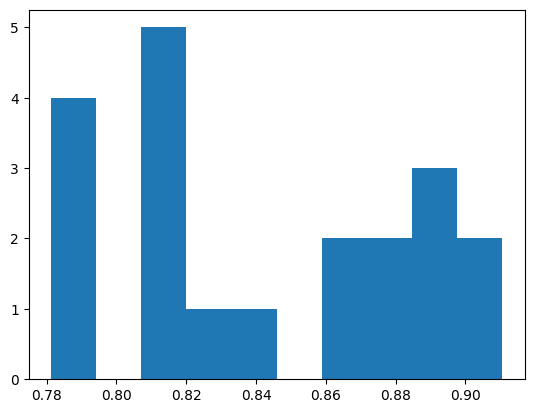

In [ ]:
plt.hist(recalls)

In [ ]:
np.mean(recalls)

0.842120319816057